# Elo Prediction

Use Regression to predict Chess Elo rating. Here are the game statistics we are trying to explore: average centipawn loss per move, blunder rate, winning chance change, openings. 

While the plots shown here are the result using all games, as an example and to limit CPU usage, the present code runs with just the games analysed with depth 20. 

## Import Packages

In [251]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


## Process Data and Add Winning Chances Column

In [47]:
winning_chance_table = pd.read_csv('winning_chances_all_moves.csv')
# Define input and output directories
input_dir = "../Cleaned_Analyzed_Games"
output_dir = "../Processed_With_WinningChances"
os.makedirs(output_dir, exist_ok=True)
# Define the intervals to use in the process_chess_data function
intervals = np.arange(-13, 13.2, 0.2)

In [50]:
def process_chess_data(df, winning_chance_table=pd.read_csv('winning_chances_all_moves.csv'), intervals=np.arange(-13, 13.2, 0.2)):
    """
    Processes chess data by binning evaluation values, merging with winning chances,
    and computing WCL, LCL, Player, and 'a' columns.

    Parameters:
    df (pd.DataFrame): DataFrame containing chess game data with 'Evaluation', 'GameID', and 'MoveNumber' columns.
    winning_chance_table (pd.DataFrame): DataFrame containing winning chances with 'Interval', 'WinningChance', 'LosingChance', and 'TotalGames' columns.
    intervals (np.array): Numpy array of interval edges used for binning evaluations.

    Returns:
    pd.DataFrame: Modified DataFrame with additional columns added.
    """
    import numpy as np
    import pandas as pd

    df['Evaluation'] = df['Evaluation'].clip(lower=-20, upper=20)

    # Ensure intervals are rounded to one decimal place
    intervals = np.round(intervals, decimals=1)
    edges = [-np.inf] + list(intervals) + [np.inf]

    # Create bin labels
    bin_labels = []
    for i in range(len(edges) - 1):
        lower = edges[i]
        upper = edges[i + 1]
        if np.isneginf(lower):
            label = f"(-infty, {upper}]"
        elif np.isposinf(upper):
            label = f"({lower}, infty)"
        else:
            label = f"({lower}, {upper}]"
        bin_labels.append(label)

    # Ensure that the bin labels in 'winning_chance_table' match the ones we're creating
    # This is important for a correct merge
    winning_chance_table['Interval'] = winning_chance_table['Interval'].astype(str)
    bin_labels = [str(label) for label in bin_labels]

    # Bin the 'Evaluation' values in 'df' to create an 'Interval' column
    df['Interval'] = pd.cut(
        df['Evaluation'],
        bins=edges,
        labels=bin_labels,
        right=True,
        include_lowest=True,
    )

    # Ensure 'Interval' in 'df' is of type string
    df['Interval'] = df['Interval'].astype(str)

    # Select the columns to merge
    columns_to_merge = ['Interval', 'WinningChance', 'LosingChance', 'TotalGames']

    # Merge 'df' with 'winning_chance_table' on 'Interval'
    df = df.merge(
        winning_chance_table[columns_to_merge],
        on='Interval',
        how='left'
    )

    # Compute 'WCL' and 'LCL' differences per game
    df['WCL'] = df.groupby('GameID')['WinningChance'].diff().abs()
    df['LCL'] = df.groupby('GameID')['LosingChance'].diff().abs()
    df['CentipawnLoss'] = df.groupby('GameID')['Evaluation'].diff().abs()

    # Assign 'Player' based on move number
    df['Player'] = np.where(df['MoveNumber'] % 2 != 0, 'White', 'Black')

    # Compute 'a' = max(|WCL|, |LCL|) for each move
    df['a'] = df[['WCL', 'LCL']].abs().max(axis=1)

    return df


In [ ]:
# Define the function to process each file
def process_all_games(input_dir, output_dir, winning_chance_table, intervals):
    # Get all CSV files in the input directory
    file_paths = glob.glob(os.path.join(input_dir, "*_20_*.csv"))

    for file_path in file_paths:
        # Extract base filename and set the output path
        base_filename = os.path.basename(file_path)
        output_path = os.path.join(output_dir, base_filename)

        # Skip if the output file already exists
        if os.path.isfile(output_path):
            print(f"{output_path} already exists. Skipping.")
            continue

        print(f"Processing {file_path}...")

        # Load the game data
        df = pd.read_csv(file_path)

        # Process the data with process_chess_data
        df_processed = process_chess_data(df, winning_chance_table=winning_chance_table, intervals=intervals)

        # Save the processed data
        df_processed.to_csv(output_path, index=False)
        print(f"Processed data saved to {output_path}")

In [ ]:
# Run the function to process all files
process_all_games(input_dir, output_dir, winning_chance_table, intervals)

In [68]:
# display an example
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
example_table = pd.read_csv("../Processed_With_WinningChances/twic1200_16_processed.csv")
example_table.head(10)

,GameID,WhiteName,BlackName,WhiteElo,BlackElo,LineStart,WhiteFideId,BlackFideId,Year,Opening,Variation,Result,Move,Old_Evaluation,Evaluation,LineEnd,MoveNumber,Interval,WinningChance,LosingChance,TotalGames,WCL,LCL,CentipawnLoss,Player,a
0,1.0,"Grischuk,A","Leko,P",2785.0,2679.0,0.0,4126025.0,703303.0,2017.0,Queen's pawn game,Unknown,1/2-1/2,d4,0.24,0.24,39.0,1.0,"(0.2, 0.4]",43.303525,36.317098,1165016.0,NaN,NaN,NaN,White,NaN
1,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Nf6,0.21,0.21,NaN,2.0,"(0.2, 0.4]",43.303525,36.317098,1165016.0,0.000000,0.000000,0.03,Black,0.000000
2,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Bf4,0.07,0.07,NaN,3.0,"(-0.0, 0.2]",41.998415,36.837735,1106637.0,1.305110,0.520637,0.14,White,1.305110
3,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,e6,0.24,0.24,NaN,4.0,"(0.2, 0.4]",43.303525,36.317098,1165016.0,1.305110,0.520637,0.17,Black,1.305110
4,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,e3,0.16,0.16,NaN,5.0,"(-0.0, 0.2]",41.998415,36.837735,1106637.0,1.305110,0.520637,0.08,White,1.305110
5,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,c5,0.2,0.20,NaN,6.0,"(-0.0, 0.2]",41.998415,36.837735,1106637.0,0.000000,0.000000,0.04,Black,0.000000
6,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Nf3,0.21,0.21,NaN,7.0,"(0.2, 0.4]",43.303525,36.317098,1165016.0,1.305110,0.520637,0.01,White,1.305110
7,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,cxd4,0.41,0.41,NaN,8.0,"(0.4, 0.6]",44.908290,34.665863,1030371.0,1.604765,1.651235,0.20,Black,1.651235
8,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,exd4,0.39,0.39,NaN,9.0,"(0.2, 0.4]",43.303525,36.317098,1165016.0,1.604765,1.651235,0.02,White,1.651235
9,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,b6,0.39,0.39,NaN,10.0,"(0.2, 0.4]",43.303525,36.317098,1165016.0,0.000000,0.000000,0.00,Black,0.000000


## Generate Summarized Statistics per Game

### Combine the files

In [ ]:
file_paths = glob.glob("../Processed_With_WinningChances/*.csv")
data_frames = []
last_game_id = 0

for file in file_paths:
    # Load the current file
    df = pd.read_csv(file, low_memory=False)
    
    # Drop rows where only 'GameID' is NaN
    df = df[~df['GameID'].isna()]
    
    # Get unique GameIDs in this file and sort them
    unique_game_ids = sorted(df['GameID'].unique())
    id_mapping = {}
    
    # Create a mapping of original GameIDs to normalized IDs
    for i, game_id in enumerate(unique_game_ids, start=last_game_id + 1):
        id_mapping[game_id] = i  # Map each original GameID to a new, consecutive ID
    
    # Apply the mapping to the GameID column
    df['GameID'] = df['GameID'].map(id_mapping)
    
    # Update last_game_id to the maximum normalized ID used so far
    last_game_id = max(id_mapping.values())
    
    # Append the dataframe to the list
    data_frames.append(df)

    # Print diagnostic information
    print(f"Processed file: {os.path.basename(file)}, unique game count: {len(unique_game_ids)}, updated last_game_id: {last_game_id}")

# Concatenate all data frames
df = pd.concat(data_frames, ignore_index=True)

# Verify final GameID range
print(f"Final GameID range: {df['GameID'].min()} to {df['GameID'].max()}")

# Check for any missing GameIDs
missing_game_ids = sorted(set(range(1, int(df['GameID'].max()) + 1)) - set(df['GameID'].unique()))
print(f"Missing GameIDs after processing: {missing_game_ids}")
print(f"Total missing GameIDs: {len(missing_game_ids)}")

In [56]:
unique_game_counts = [pd.read_csv(file, usecols=['GameID']).nunique()['GameID'] for file in file_paths]
total_games_expected = sum(unique_game_counts)
print(f"Total expected unique GameIDs (pre-concatenation): {total_games_expected}")

Total expected unique GameIDs (pre-concatenation): 1475298


In [57]:
df.shape

(126903749, 26)

In [58]:
### Save the combined dataframe locally
output_path = "processed_chess_data.csv"
df.to_csv(output_path, index=False)
print(f"DataFrame saved to {output_path}")

DataFrame saved to processed_chess_data.csv


In [14]:
df = pd.read_csv("processed_chess_data.csv")

In [16]:
### Remove moves with "Mate in 0"
df_cleaned = df[~df['Old_Evaluation'].isin(['+M0', '-M0', 'M0'])]
print(f"Rows removed: {len(df) - len(df_cleaned)}")
print(f"Remaining rows: {len(df_cleaned)}")

Rows removed: 133681
Remaining rows: 126770068


In [18]:
df_cleaned.head(50)

,GameID,WhiteName,BlackName,WhiteElo,BlackElo,LineStart,WhiteFideId,BlackFideId,Year,Opening,...,MoveNumber,Interval,WinningChance,LosingChance,TotalGames,WCL,LCL,CentipawnLoss,Player,a
0,1,"Swiercz,D","Nepomniachtchi,I",2655.0,2771.0,0.0,1126881.0,4168119.0,2019.0,Gruenfeld,...,1.0,"(0.2, 0.4]",43.303525,36.317098,1165016.0,NaN,NaN,NaN,White,NaN
1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.0,"(0.2, 0.4]",43.303525,36.317098,1165016.0,0.000000,0.000000,0.06,Black,0.000000
2,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,"(0.2, 0.4]",43.303525,36.317098,1165016.0,0.000000,0.000000,0.03,White,0.000000
3,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.0,"(0.2, 0.4]",43.303525,36.317098,1165016.0,0.000000,0.000000,0.01,Black,0.000000
4,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5.0,"(0.2, 0.4]",43.303525,36.317098,1165016.0,0.000000,0.000000,0.03,White,0.000000
5,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,6.0,"(0.4, 0.6]",44.908290,34.665863,1030371.0,1.604765,1.651235,0.06,Black,1.651235
6,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,7.0,"(0.4, 0.6]",44.908290,34.665863,1030371.0,0.000000,0.000000,0.05,White,0.000000
7,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,8.0,"(0.4, 0.6]",44.908290,34.665863,1030371.0,0.000000,0.000000,0.01,Black,0.000000
8,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,9.0,"(0.2, 0.4]",43.303525,36.317098,1165016.0,1.604765,1.651235,0.30,White,1.651235
9,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,10.0,"(0.2, 0.4]",43.303525,36.317098,1165016.0,0.000000,0.000000,0.19,Black,0.000000


### Define functions to compute features

In [20]:
def calculate_blunder_rate(centipawn_loss, threshold=2.0):
    """Calculate blunder rate based on centipawn threshold."""
    blunders = centipawn_loss > threshold
    return blunders.mean()

def calculate_contextual_blunder_rate(wcl, threshold=25):
    blunders = wcl >= threshold  # Identify moves with WCL above the threshold
    return blunders.mean() if len(wcl) > 0 else 0.0  # Return mean blunder rate

def calculate_mistake_rate(wcl, lower_threshold=14, upper_threshold=25):
    """
    Calculate the mistake rate based on WCL thresholds.

    Parameters:
    wcl (array-like): Winning chance loss values for each move.
    lower_threshold (float): Lower bound for mistakes (default: 0.14 or 14%).
    upper_threshold (float): Upper bound for mistakes (default: 0.25 or 25%).

    Returns:
    float: Fraction of moves considered mistakes.
    """
    mistakes = (wcl >= lower_threshold) & (wcl < upper_threshold)
    return mistakes.mean() if len(wcl) > 0 else 0.0

def calculate_inaccuracy_rate(wcl, lower_threshold=7, upper_threshold=14):
    """
    Calculate the inaccuracy rate based on WCL thresholds.

    Parameters:
    wcl (array-like): Winning chance loss values for each move.
    lower_threshold (float): Lower bound for inaccuracies (default: 0.07 or 7%).
    upper_threshold (float): Upper bound for inaccuracies (default: 0.14 or 14%).

    Returns:
    float: Fraction of moves considered inaccuracies.
    """
    inaccuracies = (wcl >= lower_threshold) & (wcl < upper_threshold)
    return inaccuracies.mean() if len(wcl) > 0 else 0.0

def calculate_opening_mistake_rate(centipawn_loss, moves=15, threshold=1.0):
    """Calculate mistake rate in the opening moves."""
    opening_losses = centipawn_loss[:moves]
    mistakes = opening_losses > threshold
    return mistakes.mean()

def calculate_endgame_mistake_rate(centipawn_loss, moves=15, threshold=1.0):
    """Calculate mistake rate in the last few moves (endgame)."""
    endgame_losses = centipawn_loss[-moves:]
    mistakes = endgame_losses > threshold
    return mistakes.mean()

In [21]:
def summarize_game_stats(df):
    game_stats = []

    for game_id, game_data in df.groupby("GameID"):
        # Separate by player color before calculating metrics
        white_moves = game_data[game_data["Player"] == "White"]
        black_moves = game_data[game_data["Player"] == "Black"]

        # Get centipawn loss and winning chance loss arrays for each player
        white_centipawn_loss = white_moves["CentipawnLoss"].dropna().to_numpy()
        black_centipawn_loss = black_moves["CentipawnLoss"].dropna().to_numpy()
        white_wcl = white_moves["WCL"].dropna().to_numpy()
        black_wcl = black_moves["WCL"].dropna().to_numpy()


        total_moves = game_data["MoveNumber"].max()

        # Calculate stats for White
        white_stats = {
            "GameID": game_id,
            "Player": "White",
            "PlayerID": game_data['WhiteFideId'].iloc[0],  # Add FIDE ID
            "PlayerName": game_data['WhiteName'].iloc[0],  # Add player name
            "Avg_CPL": white_centipawn_loss.mean() * 100,
            "Avg_WCL": white_wcl.mean() if len(white_wcl) > 0 else 0,
            "Blunder_Rate": calculate_blunder_rate(white_centipawn_loss),
            "Contextual_Blunder_Rate": calculate_contextual_blunder_rate(white_wcl),
            "Mistake_Rate": calculate_mistake_rate(white_wcl),
            "Inaccuracy_Rate": calculate_inaccuracy_rate(white_wcl),
            "Std_Dev_CPL": np.std(white_centipawn_loss),
            "Std_Dev_WCL": np.std(white_wcl),
            "Opening_Mistake": calculate_opening_mistake_rate(white_centipawn_loss),
            "Endgame_Mistake": calculate_endgame_mistake_rate(white_centipawn_loss),
            "Result": 1 if game_data['Result'].iloc[0] == "1-0" else 0.5 if game_data['Result'].iloc[0] == "1/2-1/2" else 0,
            "Opening": game_data['Opening'].iloc[0],
            "TotalMoves": total_moves,
            "Elo": game_data['WhiteElo'].iloc[0]
        }

        # Calculate stats for Black
        black_stats = {
            "GameID": game_id,
            "Player": "Black",
            "PlayerID": game_data['BlackFideId'].iloc[0],  # Add FIDE ID
            "PlayerName": game_data['BlackName'].iloc[0],  # Add player name
            "Avg_CPL": black_centipawn_loss.mean() * 100,
            "Avg_WCL": black_wcl.mean() if len(black_wcl) > 0 else 0,
            "Blunder_Rate": calculate_blunder_rate(black_centipawn_loss),
            "Contextual_Blunder_Rate": calculate_contextual_blunder_rate(black_wcl),
            "Mistake_Rate": calculate_mistake_rate(black_wcl),
            "Inaccuracy_Rate": calculate_inaccuracy_rate(black_wcl),
            "Std_Dev_CPL": np.std(black_centipawn_loss),
            "Std_Dev_WCL": np.std(black_wcl),
            "Opening_Mistake": calculate_opening_mistake_rate(black_centipawn_loss),
            "Endgame_Mistake": calculate_endgame_mistake_rate(black_centipawn_loss),
            "Result": 1 if game_data['Result'].iloc[0] == "0-1" else 0.5 if game_data['Result'].iloc[0] == "1/2-1/2" else 0,
            "Opening": game_data['Opening'].iloc[0],
            "TotalMoves": total_moves,
            "Elo": game_data['BlackElo'].iloc[0]
        }

        game_stats.append(white_stats)
        game_stats.append(black_stats)

    return pd.DataFrame(game_stats)


In [ ]:
df_summary = summarize_game_stats(df_cleaned)
df_summary.shape

In [24]:
### Save the summary dataframe locally
output_path = "summary_chess_data.csv"
df_summary.to_csv(output_path, index=False)
print(f"DataFrame saved to {output_path}")

DataFrame saved to summary_chess_data.csv


## Import Data
Summarized data is saved locally so that we can directly import for future uses. 

In [ ]:
### Load the summary data
df_summary = pd.read_csv("summary_chess_data.csv")

In [ ]:
df_white = df_summary[df_summary['Player'] == 'White'].reset_index(drop=True)
df_black = df_summary[df_summary['Player'] == 'Black'].reset_index(drop=True)

In [252]:
df_white.head(5)

,GameID,Player,PlayerID,PlayerName,Avg_CPL,Avg_WCL,Blunder_Rate,Contextual_Blunder_Rate,Mistake_Rate,Inaccuracy_Rate,Std_Dev_CPL,Std_Dev_WCL,Opening_Mistake,Endgame_Mistake,Result,Opening,TotalMoves,Elo,Opponent_Rating,Rating_Difference
0,1,White,1126881.0,"Swiercz,D",10.606061,0.664876,0.0,0.0,0.0,0.000000,0.104038,1.231299,0.0,0.000000,0.5,Gruenfeld,68.0,2655.0,2771.0,-116.0
1,2,White,4126025.0,"Grischuk,A",5.688312,0.602159,0.0,0.0,0.0,0.000000,0.084765,1.262897,0.0,0.000000,0.5,QGD,155.0,2771.0,2642.0,129.0
2,3,White,2021285.0,"Lenderman,A",7.310345,1.043382,0.0,0.0,0.0,0.034483,0.144368,2.220783,0.0,0.000000,0.5,Queen's Indian,60.0,2637.0,2725.0,-88.0
3,4,White,24101605.0,"Artemiev,V",14.136364,1.255212,0.0,0.0,0.0,0.022727,0.177682,2.046990,0.0,0.066667,1.0,English opening,89.0,2736.0,2603.0,133.0
4,5,White,4650891.0,"Naiditsch,A",11.166667,1.389447,0.0,0.0,0.0,0.055556,0.158263,2.388078,0.0,0.000000,0.5,Ruy Lopez,109.0,2710.0,2683.0,27.0


In [253]:
df_black.tail(5)

,GameID,Player,PlayerID,PlayerName,Avg_CPL,Avg_WCL,Blunder_Rate,Contextual_Blunder_Rate,Mistake_Rate,Inaccuracy_Rate,Std_Dev_CPL,Std_Dev_WCL,Opening_Mistake,Endgame_Mistake,Result,Opening,TotalMoves,Elo,Opponent_Rating,Rating_Difference
1475293,1475294,Black,14113171.0,"Vovk,Y",18.456522,1.868574,0.000000,0.000000,0.021739,0.021739,0.285259,3.513880,0.0,0.066667,0.0,QGD,93.0,2600.0,2734.0,-134.0
1475294,1475295,Black,309095.0,"Navara,D",24.608696,1.488083,0.043478,0.000000,0.043478,0.043478,0.519956,3.407222,0.0,0.066667,1.0,Sicilian,46.0,2739.0,2529.0,210.0
1475295,1475296,Black,1129708.0,"Kolosowski,M",15.588235,1.064299,0.000000,0.000000,0.000000,0.029412,0.127559,1.796674,0.0,0.000000,1.0,English,68.0,2421.0,2634.0,-213.0
1475296,1475297,Black,1111914.0,"Miton,K",13.459459,1.210554,0.000000,0.000000,0.000000,0.000000,0.166613,1.680620,0.0,0.000000,1.0,English opening,74.0,2618.0,2285.0,333.0
1475297,1475298,Black,1125923.0,"Dubinski,M",35.125000,3.450104,0.020833,0.020833,0.041667,0.041667,0.441544,5.989150,0.0,0.066667,0.0,Catalan,97.0,2275.0,2583.0,-308.0


In [254]:
# Add Opponent_Rating for df_white and df_black
df_white['Opponent_Rating'] = df_black['Elo']
df_black['Opponent_Rating'] = df_white['Elo']

In [255]:
# Add Rating_Difference to df_white and df_black
df_white["Rating_Difference"] = df_white["Elo"] - df_white["Opponent_Rating"]
df_black["Rating_Difference"] = df_black["Elo"] - df_black["Opponent_Rating"]

# Check the result
print(df_white[["Player", "Elo", "Opponent_Rating", "Rating_Difference"]].head())
print(df_black[["Player", "Elo", "Opponent_Rating", "Rating_Difference"]].head())

  Player     Elo  Opponent_Rating  Rating_Difference
0  White  2655.0           2771.0             -116.0
1  White  2771.0           2642.0              129.0
2  White  2637.0           2725.0              -88.0
3  White  2736.0           2603.0              133.0
4  White  2710.0           2683.0               27.0
  Player     Elo  Opponent_Rating  Rating_Difference
0  Black  2771.0           2655.0              116.0
1  Black  2642.0           2771.0             -129.0
2  Black  2725.0           2637.0               88.0
3  Black  2603.0           2736.0             -133.0
4  Black  2683.0           2710.0              -27.0


## Data Exploration on All Data

### Winning Chance Loss

In [80]:
df_white['Avg_WCL'].describe()

count    1.475298e+06
mean     2.780917e+00
std      1.374035e+00
min      0.000000e+00
25%      1.856952e+00
50%      2.546643e+00
75%      3.445391e+00
max      4.323826e+01
Name: Avg_WCL, dtype: float64

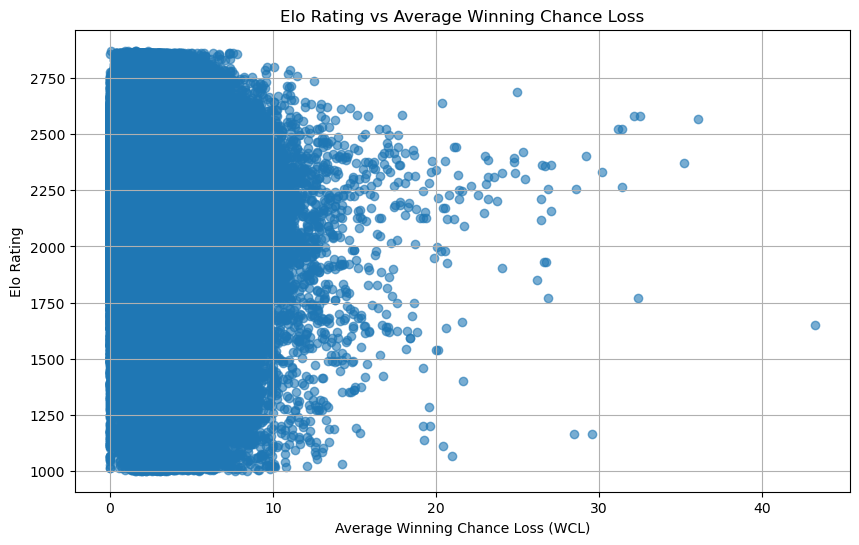

In [81]:
# Scatter plot of Avg_WCL vs Elo rating
plt.figure(figsize=(10, 6))
plt.scatter(df_white['Avg_WCL'], df_white['Elo'], alpha=0.6)
plt.title('Elo Rating vs Average Winning Chance Loss')
plt.xlabel('Average Winning Chance Loss (WCL)')
plt.ylabel('Elo Rating')
plt.grid(True)
plt.show()

### Standard Deviation of CPL

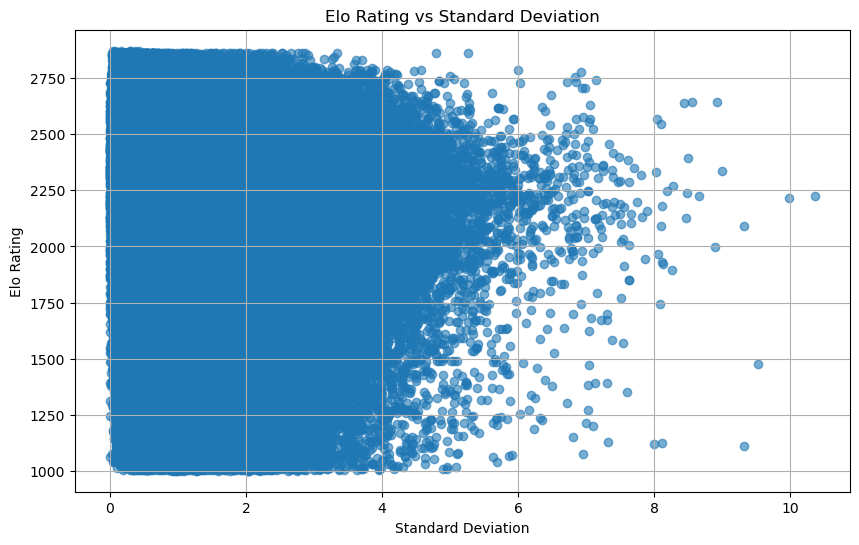

In [83]:
# Scatter plot of std vs Elo rating
plt.figure(figsize=(10, 6))
plt.scatter(df_white['Std_Dev_CPL'], df_white['Elo'], alpha=0.6)
plt.title('Elo Rating vs Standard Deviation')
plt.xlabel('Standard Deviation')
plt.ylabel('Elo Rating')
plt.grid(True)
plt.show()

### Opponent Rating

In [100]:
df_white['Opponent_Rating'].describe()

count    1.449071e+06
mean     2.236983e+03
std      2.874132e+02
min      1.001000e+03
25%      2.086000e+03
50%      2.277000e+03
75%      2.433000e+03
max      2.872000e+03
Name: Opponent_Rating, dtype: float64

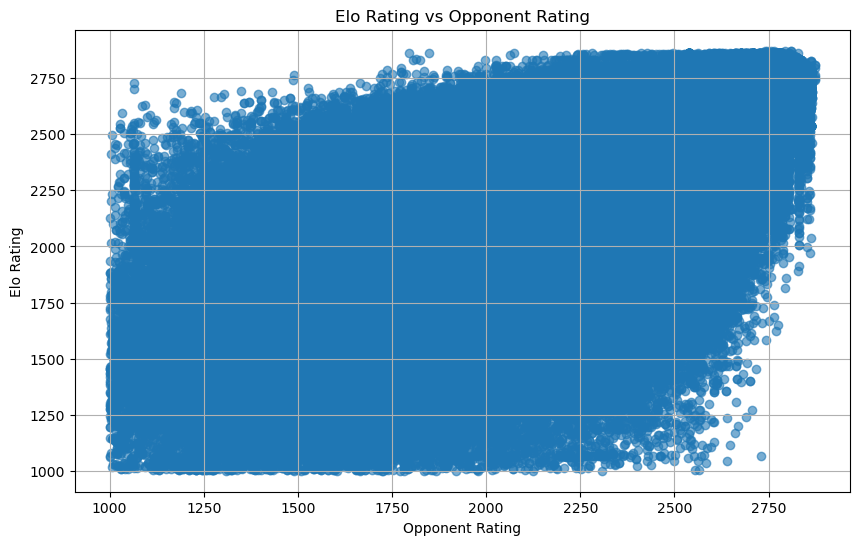

In [101]:
# Scatter plot of Opponent Rating vs Elo rating
plt.figure(figsize=(10, 6))
plt.scatter(df_white['Opponent_Rating'], df_white['Elo'], alpha=0.6)
plt.title('Elo Rating vs Opponent Rating')
plt.xlabel('Opponent Rating')
plt.ylabel('Elo Rating')
plt.grid(True)
plt.show()

## Regression on All Games

### Elo Distribution

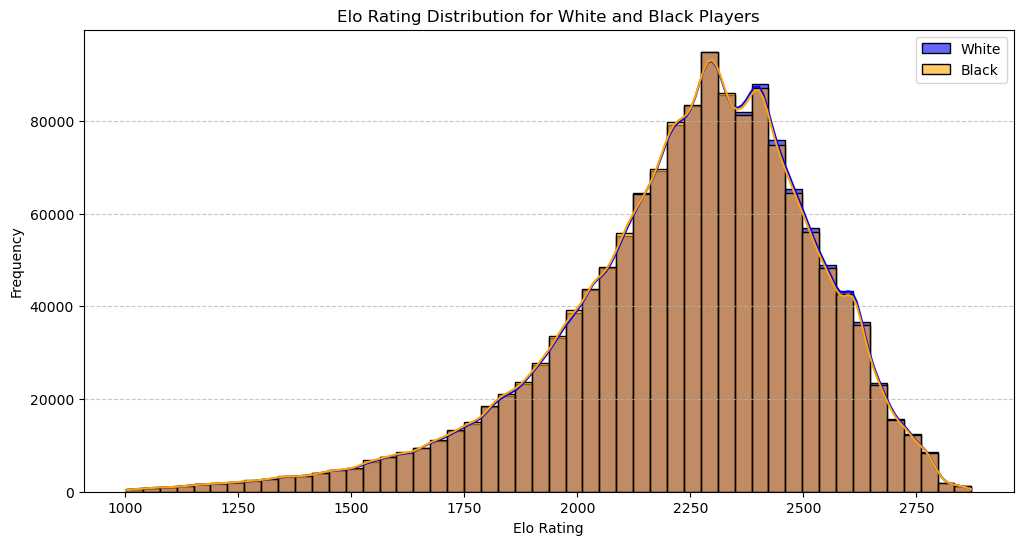

In [12]:
# Plot Elo distribution for df_white and df_black
plt.figure(figsize=(12, 6))

sns.histplot(df_white['Elo'], bins=50, kde=True, color='blue', label='White', alpha=0.6)
sns.histplot(df_black['Elo'], bins=50, kde=True, color='orange', label='Black', alpha=0.6)

plt.title('Elo Rating Distribution for White and Black Players')
plt.xlabel('Elo Rating')
plt.ylabel('Frequency')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Most games are around the 2200 - 2400 elo range, and there are much fewer games in the lower end (<1500) and upper end (>2750). This could be problematic if we want to accurately predict the elo for players in these underrepresented elo ranges.

In [13]:
print(df_white.columns)

Index(['GameID', 'Player', 'Avg_CPL', 'Avg_WCL', 'Blunder_Rate',
       'Contextual_Blunder_Rate', 'Mistake_Rate', 'Inaccuracy_Rate',
       'Std_Dev_CPL', 'Std_Dev_WCL', 'Opening_Mistake', 'Endgame_Mistake',
       'Result', 'Opening', 'TotalMoves', 'Elo', 'Opponent_Rating',
       'Rating_Difference'],
      dtype='object')


### Pick Significant Variables

First, look at the correlation between the numerical variables with Elo rating to determine how good each predictor is. 

In [119]:
#Avg_CPL	Avg_WCL	Blunder_Rate	Contextual_Blunder_Rate	Mistake_Rate	Inaccuracy_Rate	Std_Dev_CPL	Std_Dev_WCL	Opening_Mistake	Endgame_Mistake	Result	Opening	TotalMoves	Elo	Opponent_Rating
numeric_columns = ['Avg_CPL', 'Avg_WCL', 'Blunder_Rate', 'Contextual_Blunder_Rate', 'Mistake_Rate', 'Inaccuracy_Rate', 'Std_Dev_CPL', 'Std_Dev_WCL', 'Opening_Mistake', 'Endgame_Mistake', 'TotalMoves', 'Elo', 'Opponent_Rating']
# Compute correlation with Elo
correlations = df_white[numeric_columns].corr()['Elo'].sort_values(ascending=False)
print(correlations)

Elo                        1.000000
Opponent_Rating            0.581647
TotalMoves                 0.056808
Contextual_Blunder_Rate   -0.102707
Mistake_Rate              -0.132500
Inaccuracy_Rate           -0.148119
Std_Dev_WCL               -0.153836
Std_Dev_CPL               -0.155425
Endgame_Mistake           -0.167316
Avg_WCL                   -0.185546
Blunder_Rate              -0.186519
Opening_Mistake           -0.198433
Avg_CPL                   -0.222769
Name: Elo, dtype: float64


Only 'Opponent_Rating' has a decent positive correlation with Elo rating of a player. There are potentials to explore other features that are more significantly correlates with Elo. 

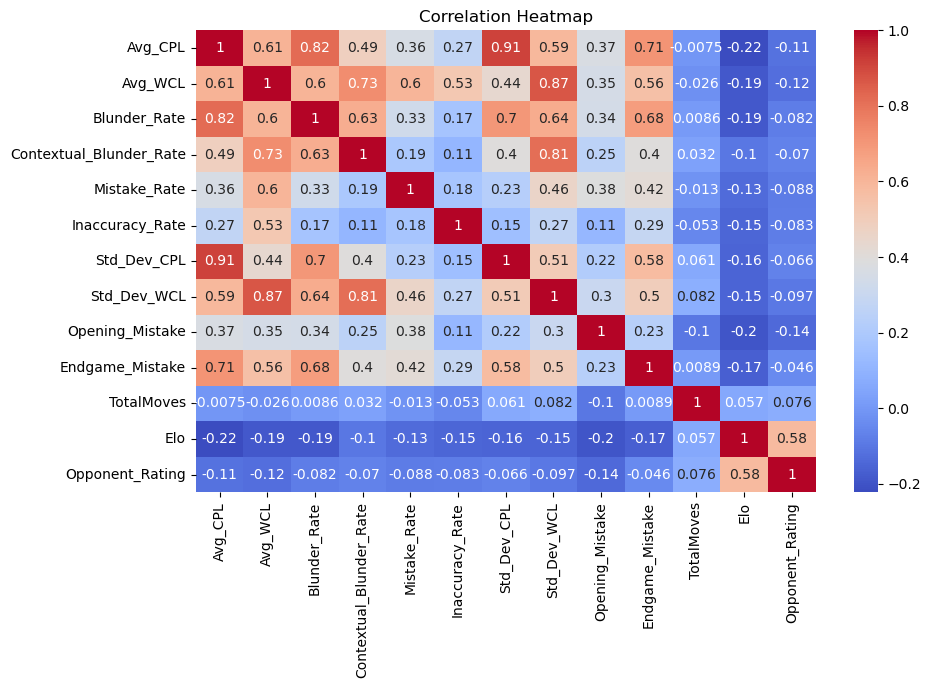

In [120]:
plt.figure(figsize=(10, 6))
sns.heatmap(df_white[numeric_columns].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

### What about the Categorical Variables? 

Mean Elo by Result:
Result
0.0    2156.780888
0.5    2283.355567
1.0    2286.197050
Name: Elo, dtype: float64


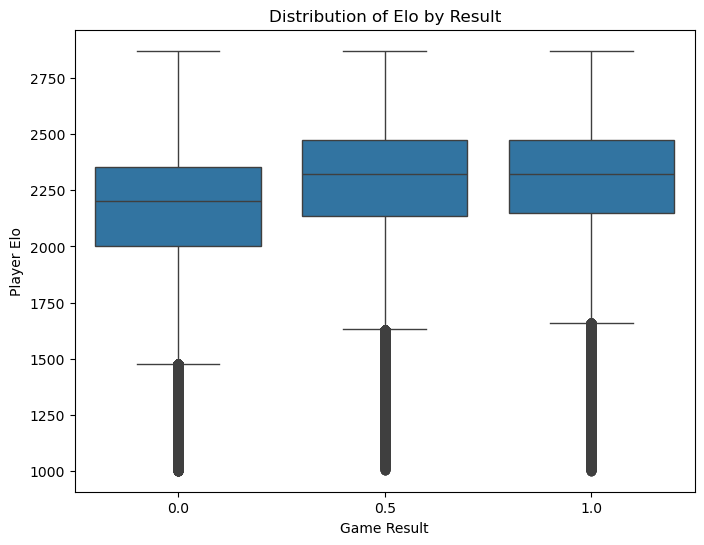

In [122]:
# Analyze Elo by game result
result_grouped = df_white.groupby('Result')['Elo'].mean().sort_values()
print("Mean Elo by Result:")
print(result_grouped)

# Visualize the distribution of Elo by Result
plt.figure(figsize=(8, 6))
sns.boxplot(data=df_white, x='Result', y='Elo')
plt.title("Distribution of Elo by Result")
plt.xlabel("Game Result")
plt.ylabel("Player Elo")
plt.show()

Mean Elo by Top Openings:
Opening
Ruy Lopez            2304.651205
Reti opening         2289.591907
English              2284.916546
QGD                  2282.087532
English opening      2269.057247
King's Indian        2255.522597
Caro-Kann            2225.702706
French               2217.852155
Sicilian             2209.470339
Queen's pawn game    2208.086836
Name: Elo, dtype: float64


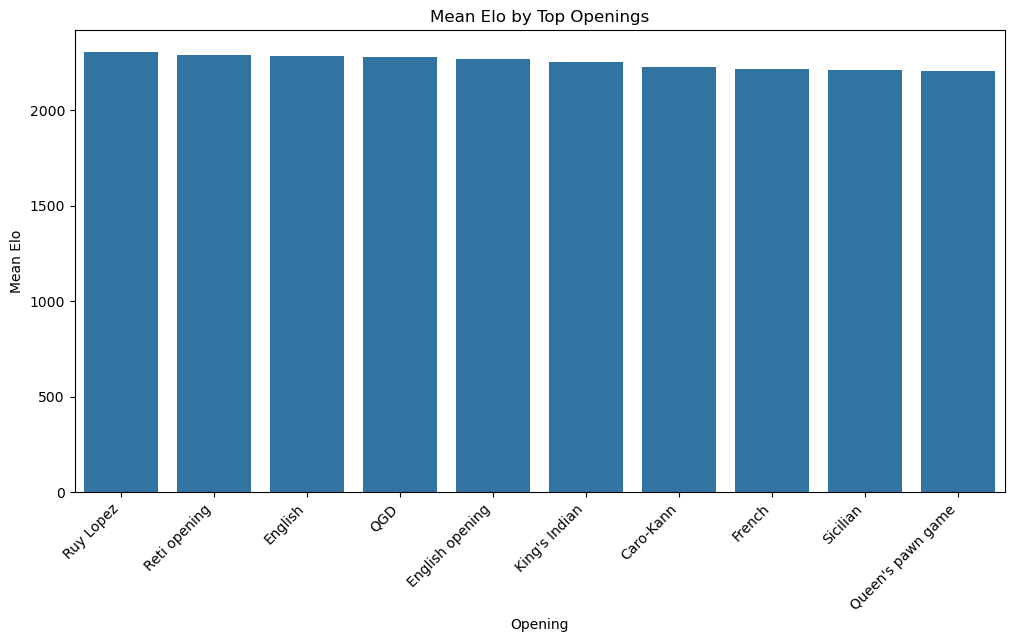

In [123]:
# Find the most frequent openings
top_openings = df_white['Opening'].value_counts().head(10).index

# Filter for only the top openings
df_top_openings = df_white[df_white['Opening'].isin(top_openings)]

# Group by opening and calculate the mean Elo
opening_grouped = df_top_openings.groupby('Opening')['Elo'].mean().sort_values(ascending=False)
print("Mean Elo by Top Openings:")
print(opening_grouped)

# Visualize mean Elo for the top openings
plt.figure(figsize=(12, 6))
sns.barplot(x=opening_grouped.index, y=opening_grouped.values)
plt.xticks(rotation=45, ha='right')
plt.title("Mean Elo by Top Openings")
plt.xlabel("Opening")
plt.ylabel("Mean Elo")
plt.show()


### Train Test Split
First, let's remove the outliers. I pick games with > 15 Avg_WCL as outliers (extremely low quality games). This threshold is debatable and should be further tested. 

In [129]:
print(df_white.shape)
# Remove outliers with Avg_WCL > 15
threshold_wcl = 15
df_white_cleaned = df_white[df_white['Avg_WCL'] <= threshold_wcl]
df_black_cleaned = df_black[df_black['Avg_WCL'] <= threshold_wcl]

print("Remaining white games:", len(df_white_cleaned))
print("Remaining black games:", len(df_black_cleaned))

(1475298, 17)
Remaining white games: 1475053
Remaining black games: 1475002


In [158]:
# White Player Train-Test Split
df_white_cleaned = df_white_cleaned.dropna()
df_white_cleaned['Elo_bin'] = pd.cut(df_white_cleaned['Elo'], bins=np.arange(1000, 2800, 200), labels=False)
df_white_cleaned = df_white_cleaned.dropna(subset=['Elo_bin'])

# Define features (X) and target (y)
X_white = df_white_cleaned.drop(columns=['Elo', 'Elo_bin', 'GameID', 'Player', 'Opening', 'Contextual_Blunder_Rate', 'Std_Dev_WCL', 'Result', 'TotalMoves'])
y_white = df_white_cleaned['Elo']
stratify_bins_white = df_white_cleaned['Elo_bin']

# Stratified Shuffle Split
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in splitter.split(X_white, stratify_bins_white):
    X_train_white, X_test_white = X_white.iloc[train_index], X_white.iloc[test_index]
    y_train_white, y_test_white = y_white.iloc[train_index], y_white.iloc[test_index]

print("Training set Elo bin distribution (White):")
print(pd.Series(stratify_bins_white.iloc[train_index]).value_counts())

print("\nTest set Elo bin distribution (White):")
print(pd.Series(stratify_bins_white.iloc[test_index]).value_counts())

# Black Player Train-Test Split
df_black_cleaned = df_black_cleaned.dropna()
df_black_cleaned['Elo_bin'] = pd.cut(df_black_cleaned['Elo'], bins=np.arange(1000, 2800, 200), labels=False)
df_black_cleaned = df_black_cleaned.dropna(subset=['Elo_bin'])

# Define features (X) and target (y)
X_black = df_black_cleaned.drop(columns=['Elo', 'Elo_bin', 'GameID', 'Player', 'Opening', 'Contextual_Blunder_Rate', 'Std_Dev_WCL', 'Result', 'TotalMoves'])
y_black = df_black_cleaned['Elo']
stratify_bins_black = df_black_cleaned['Elo_bin']

# Stratified Shuffle Split
for train_index, test_index in splitter.split(X_black, stratify_bins_black):
    X_train_black, X_test_black = X_black.iloc[train_index], X_black.iloc[test_index]
    y_train_black, y_test_black = y_black.iloc[train_index], y_black.iloc[test_index]

print("Training set Elo bin distribution (Black):")
print(pd.Series(stratify_bins_black.iloc[train_index]).value_counts())

print("\nTest set Elo bin distribution (Black):")
print(pd.Series(stratify_bins_black.iloc[test_index]).value_counts())

Training set Elo bin distribution (White):
Elo_bin
6    362734
7    261680
5    233730
4    111211
3     46139
2     20477
1      9147
0      3621
Name: count, dtype: int64

Test set Elo bin distribution (White):
Elo_bin
6    90684
7    65420
5    58433
4    27803
3    11535
2     5119
1     2286
0      905
Name: count, dtype: int64
Training set Elo bin distribution (Black):
Elo_bin
6    362934
7    257891
5    235280
4    113260
3     47198
2     20866
1      9409
0      3737
Name: count, dtype: int64

Test set Elo bin distribution (Black):
Elo_bin
6    90734
7    64473
5    58820
4    28315
3    11799
2     5217
1     2352
0      934
Name: count, dtype: int64


### Linear Regression Model

In [159]:
# Function to run regression for a given train/test split
def run_regression(X_train, X_test, y_train, y_test, player_color):
    # Apply Standard Scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Initialize and train the linear regression model
    model = LinearRegression()
    model.fit(X_train_scaled, y_train)
    
    # Predict on the test set
    y_pred = model.predict(X_test_scaled)
    
    # Evaluate the model
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)  # Root Mean Squared Error
    r2 = r2_score(y_test, y_pred)
    
    # Print results
    print(f"\nResults for {player_color} Players:")
    print("Mean Absolute Error (MAE):", mae)
    print("Mean Squared Error (MSE):", mse)
    print("Root Mean Square Error (RMSE):", rmse)
    print("R² Score:", r2)
    
    return model

In [186]:
# White Player Regression
print("Running regression for White players...")
model_white = run_regression(X_train_white, X_test_white, y_train_white, y_test_white, "White")

Running regression for White players...

Results for White Players:
Mean Absolute Error (MAE): 165.7660549057749
Mean Squared Error (MSE): 45941.698216899225
Root Mean Square Error (RMSE): 214.34014606904424
R² Score: 0.32358402213858595


In [161]:
# Black Player Regression
print("Running regression for Black players...")
model_black = run_regression(X_train_black, X_test_black, y_train_black, y_test_black, "Black")

Running regression for Black players...

Results for Black Players:
Mean Absolute Error (MAE): 163.95925505391804
Mean Squared Error (MSE): 45021.85534332982
Root Mean Square Error (RMSE): 212.18354164102792
R² Score: 0.3434021764916271


In [185]:
# Get coefficients and intercept
coefficients = pd.DataFrame(
    {"Feature": X_train_white.columns, "Coefficient": model_white.coef_}
).sort_values(by="Coefficient", ascending=False)
intercept = model_white.intercept_

print(f"Intercept: {intercept}\n")
print(coefficients)

Intercept: 2210.522348267777

           Feature  Coefficient
8  Opponent_Rating   135.037231
5      Std_Dev_CPL    23.976756
1          Avg_WCL    16.234359
3     Mistake_Rate    -2.656320
2     Blunder_Rate    -8.272235
7  Endgame_Mistake   -10.857007
6  Opening_Mistake   -18.557827
4  Inaccuracy_Rate   -19.764081
0          Avg_CPL   -47.152056


In [163]:
def plot_regression_results(y_test, y_pred, player_color):
    # Actual vs Predicted Plot
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, alpha=0.5, color="blue", label="Predictions")
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label="Perfect Prediction")
    plt.title(f"Actual vs Predicted Elo ({player_color} Players)")
    plt.xlabel("Actual Elo")
    plt.ylabel("Predicted Elo")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Residual Plot
    residuals = y_test - y_pred
    plt.figure(figsize=(8, 6))
    plt.scatter(y_pred, residuals, alpha=0.5, color="orange")
    plt.axhline(y=0, color='r', linestyle='--', label="Zero Residual Line")
    plt.title(f"Residuals Plot ({player_color} Players)")
    plt.xlabel("Predicted Elo")
    plt.ylabel("Residuals (Actual - Predicted)")
    plt.legend()
    plt.tight_layout()
    plt.show()

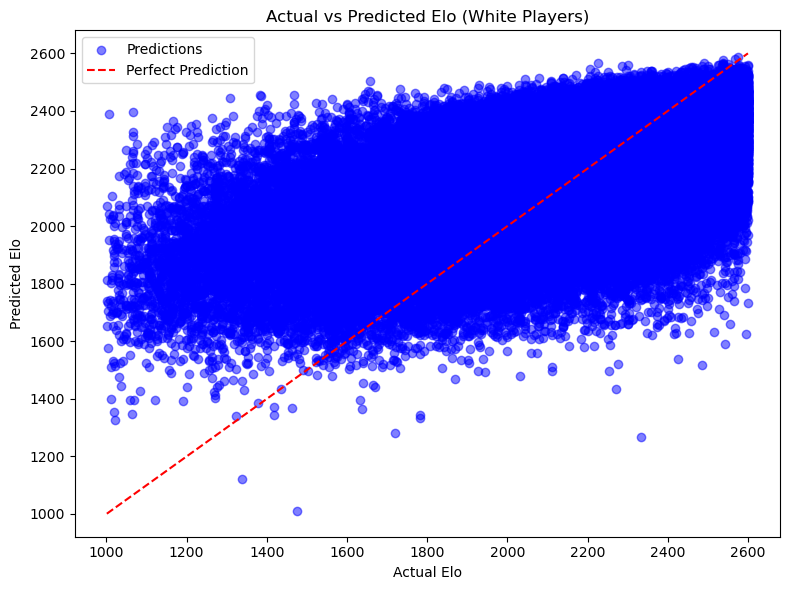

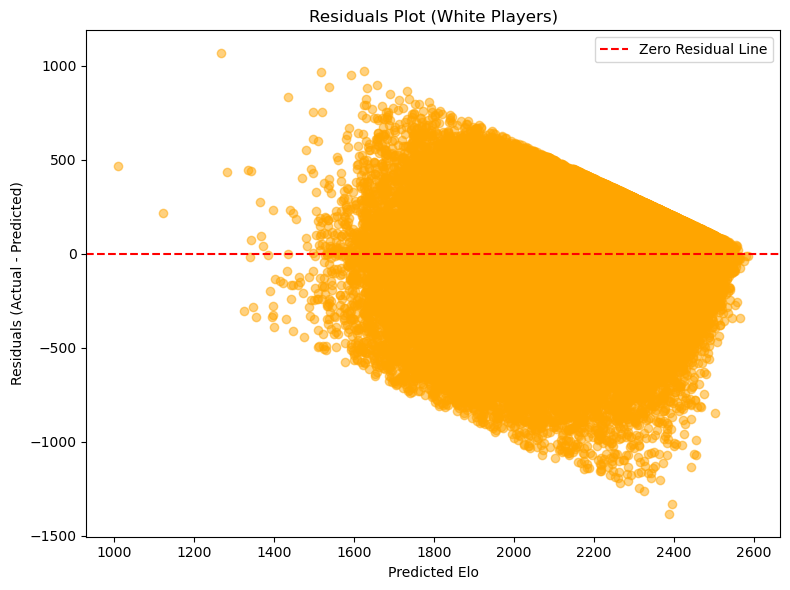

In [164]:
# Predict for White players
y_pred_white = model_white.predict(StandardScaler().fit_transform(X_test_white))
plot_regression_results(y_test_white, y_pred_white, "White")


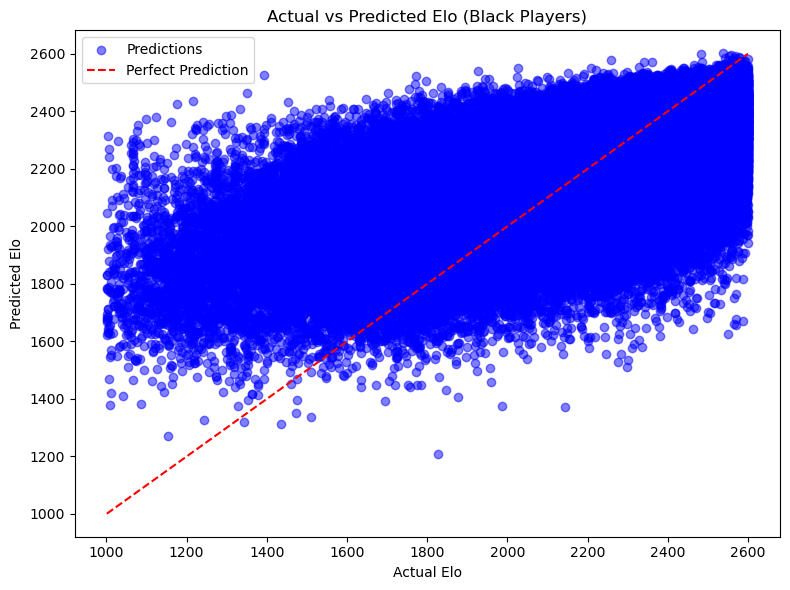

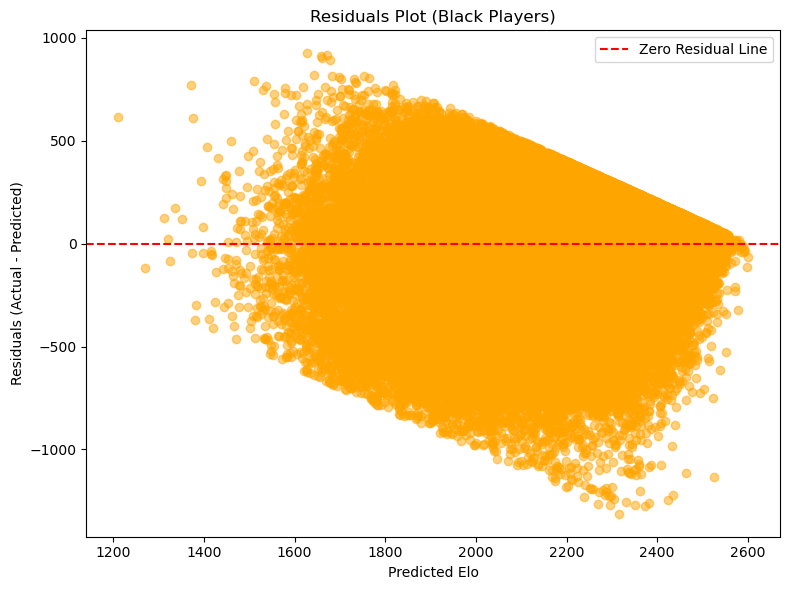

In [165]:
# Predict for Black players
y_pred_black = model_black.predict(StandardScaler().fit_transform(X_test_black))
plot_regression_results(y_test_black, y_pred_black, "Black")

### Maybe Balance the Training Data across all Elo Ranges? 



In [169]:
def balance_full_dataset(df, target_column, bins_column, bins):
    balanced_dfs = []
    for bin_value in bins:
        bin_data = df[df[bins_column] == bin_value]
        if not bin_data.empty:
            n_samples = min(len(bin_data), 20000)  # Adjust this number as needed
            balanced_dfs.append(bin_data.sample(n_samples, random_state=42, replace=len(bin_data) < n_samples))
    return pd.concat(balanced_dfs, axis=0).reset_index(drop=True)

In [171]:
# Remove original testing data from the cleaned datasets
train_indices_white = ~df_white_cleaned.index.isin(X_test_white.index)
train_indices_black = ~df_black_cleaned.index.isin(X_test_black.index)

df_white_training_only = df_white_cleaned[train_indices_white]
df_black_training_only = df_black_cleaned[train_indices_black]

# Balance the training data
bins_white = df_white_training_only['Elo_bin'].unique()
df_white_balanced = balance_full_dataset(df_white_training_only, 'Elo', 'Elo_bin', bins_white)

bins_black = df_black_training_only['Elo_bin'].unique()
df_black_balanced = balance_full_dataset(df_black_training_only, 'Elo', 'Elo_bin', bins_black)

# Verify distributions
print("Balanced White Training Distribution:")
print(df_white_balanced['Elo_bin'].value_counts())

print("\nBalanced Black Training Distribution:")
print(df_black_balanced['Elo_bin'].value_counts())

# Use the original testing data
X_test_balanced_white = X_test_white.copy()
y_test_balanced_white = y_test_white.copy()

X_test_balanced_black = X_test_black.copy()
y_test_balanced_black = y_test_black.copy()

# Define balanced training data for white and black
X_train_balanced_white = df_white_balanced.drop(columns=['Elo', 'Elo_bin', 'GameID', 'Player', 'Opening', 'Contextual_Blunder_Rate', 
                                                         'Std_Dev_WCL', 'Result', 'TotalMoves'])
y_train_balanced_white = df_white_balanced['Elo']

X_train_balanced_black = df_black_balanced.drop(columns=['Elo', 'Elo_bin', 'GameID', 'Player', 'Opening', 'Contextual_Blunder_Rate', 
                                                         'Std_Dev_WCL', 'Result', 'TotalMoves'])
y_train_balanced_black = df_black_balanced['Elo']

# Verify shapes
print("Shape of Balanced Training Data (White):", X_train_balanced_white.shape)
print("Shape of Balanced Testing Data (White):", X_test_balanced_white.shape)
print("Shape of Balanced Training Data (Black):", X_train_balanced_black.shape)
print("Shape of Balanced Testing Data (Black):", X_test_balanced_black.shape)

Balanced White Training Distribution:
Elo_bin
7    20000
4    20000
6    20000
5    20000
3    20000
2    20000
1     9147
0     3621
Name: count, dtype: int64

Balanced Black Training Distribution:
Elo_bin
7    20000
4    20000
6    20000
5    20000
3    20000
2    20000
1     9409
0     3737
Name: count, dtype: int64
Shape of Balanced Training Data (White): (132768, 9)
Shape of Balanced Testing Data (White): (262185, 9)
Shape of Balanced Training Data (Black): (133146, 9)
Shape of Balanced Testing Data (Black): (262644, 9)


In [174]:
# White Player Regression
print("Running regression for White players...")
model_white_balanced = run_regression(X_train_balanced_white, X_test_balanced_white, y_train_balanced_white, y_test_balanced_white, "White")

Running regression for White players...

Results for White Players:
Mean Absolute Error (MAE): 219.08221273555978
Mean Squared Error (MSE): 71996.63539777322
Root Mean Square Error (RMSE): 268.32188766064763
R² Score: -0.060032093402301756


OK, the result is very poor. Maybe this does not help. 

### Will Nonlinear Models help? Random Forest Regression

In [182]:
from sklearn.ensemble import RandomForestRegressor

def run_random_forest(X_train, X_test, y_train, y_test, player_color):
    # Apply Standard Scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Initialize and train the Random Forest model
    model = RandomForestRegressor(n_estimators=100, random_state=42, max_depth=10)
    model.fit(X_train_scaled, y_train)
    
    # Predict on the test set
    y_pred = model.predict(X_test_scaled)
    
    # Evaluate the model
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)  # Root Mean Squared Error
    r2 = r2_score(y_test, y_pred)
    
    # Print results
    print(f"\nResults for {player_color} Players (Random Forest):")
    print("Mean Absolute Error (MAE):", mae)
    print("Mean Squared Error (MSE):", mse)
    print("Root Mean Square Error (RMSE):", rmse)
    print("R² Score:", r2)
    
    return model

In [183]:
model_white_rf = run_random_forest(X_train_white, X_test_white, y_train_white, y_test_white, "White")


Results for White Players (Random Forest):
Mean Absolute Error (MAE): 162.0657393362047
Mean Squared Error (MSE): 44111.66217789782
Root Mean Square Error (RMSE): 210.02776525473442
R² Score: 0.3505282942244493


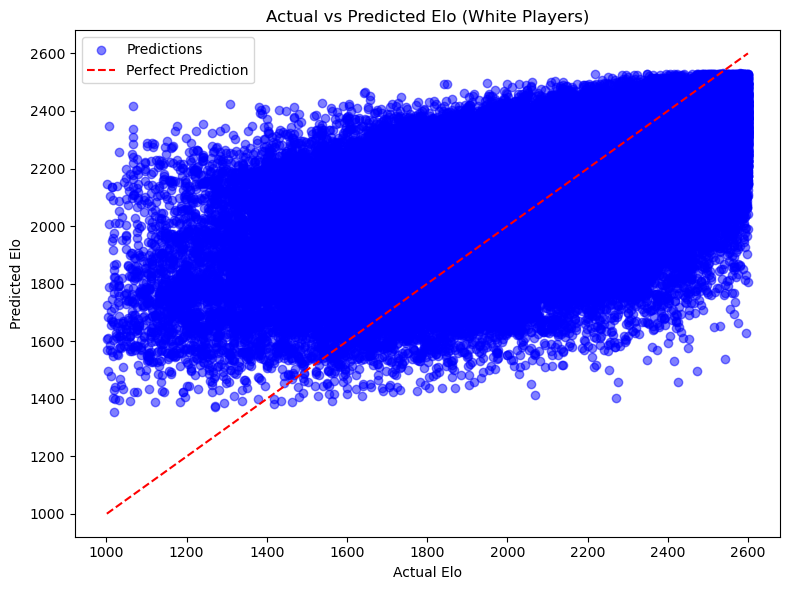

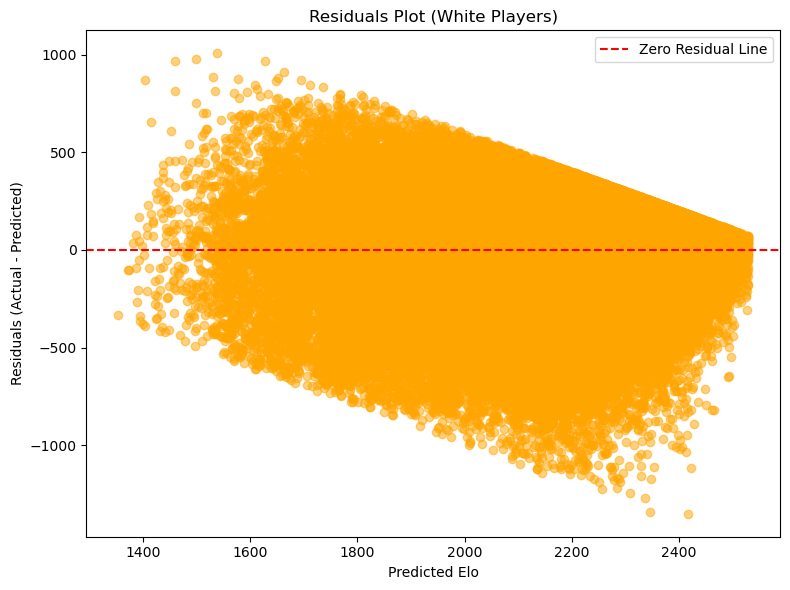

In [184]:
# Predict for White players
y_pred_rf_white = model_white_rf.predict(StandardScaler().fit_transform(X_test_white))
plot_regression_results(y_test_white, y_pred_rf_white, "White")

## Aggregate Player Performance over Multiple Games

From the previous plots and regression models, it is clear that relying on player performance alone in a single match is insufficient to accurately predict one's elo. Therefore, the next idea is to aggregate each player's performance over several games. 

### Group Games by Player

In [38]:
df_total = pd.concat([df_white, df_black])

In [60]:
df_total['PlayerID'].nunique()

67405

In [45]:
duplicate_names = df_total.groupby("PlayerName")["PlayerID"].nunique()
duplicates = duplicate_names[duplicate_names > 1]
print(duplicates)

PlayerName
Al-Takrori,Husam        2
Alekseev,Mikhail        2
Aryan Mehta             3
Ayats Llobera,Gerard    2
Aydin,Akin              2
                       ..
Wu,Yuxuan               2
Youssef,Mohamed         2
Zhao,Chenyu             2
Zhukov,Ivan             2
Zielinski,Tomasz        2
Name: PlayerID, Length: 93, dtype: int64


In [49]:
# Group by PlayerID and count unique PlayerName entries
id_to_names = df_total.groupby("PlayerID")["PlayerName"].nunique()

# Filter IDs with more than one associated name
multiple_names = id_to_names[id_to_names > 1]
print(multiple_names)

PlayerID
110825.0       2
209546.0       2
236730.0       2
301264.0       2
302775.0       2
              ..
54764998.0     2
55653537.0     2
66203287.0     2
324226763.0    2
366195016.0    2
Name: PlayerName, Length: 750, dtype: int64


In [179]:
player_id = 4100018.0  # Replace with an actual ID from the output
df_filtered = df_total[df_total["PlayerID"] == player_id]
print(df_filtered[["PlayerID", "PlayerName", "Elo"]])

          PlayerID  PlayerName     Elo
128951   4100018.0  Kasparov,G  2812.0
128960   4100018.0  Kasparov,G  2812.0
128969   4100018.0  Kasparov,G  2812.0
128978   4100018.0  Kasparov,G  2812.0
128987   4100018.0  Kasparov,G  2812.0
...            ...         ...     ...
1012842  4100018.0  Kasparov,G  2812.0
1012856  4100018.0  Kasparov,G  2812.0
1012874  4100018.0  Kasparov,G  2812.0
1012883  4100018.0  Kasparov,G  2812.0
1012892  4100018.0  Kasparov,G  2812.0

[76 rows x 3 columns]


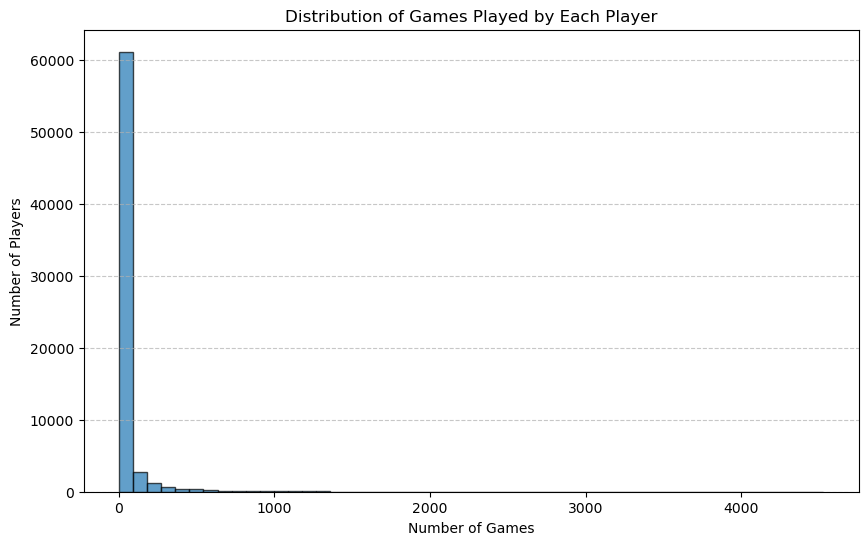

Summary Statistics for Games Played per Player:
count    67405.000000
mean        43.774141
std        139.878655
min          1.000000
25%          4.000000
50%         10.000000
75%         25.000000
max       4527.000000
Name: count, dtype: float64


In [61]:
# Count appearances for each unique PlayerID
player_game_counts = df_total['PlayerID'].value_counts()

# Plot the distribution
plt.figure(figsize=(10, 6))
plt.hist(player_game_counts, bins=50, edgecolor='black', alpha=0.7)
plt.title("Distribution of Games Played by Each Player")
plt.xlabel("Number of Games")
plt.ylabel("Number of Players")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Print some summary statistics
print("Summary Statistics for Games Played per Player:")
print(player_game_counts.describe())

In [125]:
# Set a minimum number of games threshold
min_games_threshold = 10

# Filter players with at least the minimum number of games
filtered_players = player_game_counts[player_game_counts >= min_games_threshold].index
df_filtered = df_total[df_total['PlayerID'].isin(filtered_players)]
df_filtered.shape

(2800877, 20)

In [126]:
# Function to aggregate stats for a single player
def aggregate_player_stats(player_data):
    total_moves = player_data['TotalMoves'].sum()
    return pd.Series({
        "Avg_CPL": (player_data['Avg_CPL'] * player_data['TotalMoves']).sum() / total_moves,
        "Avg_WCL": (player_data['Avg_WCL'] * player_data['TotalMoves']).sum() / total_moves,
        "Blunder_Rate": (player_data['Blunder_Rate'] * player_data['TotalMoves']).sum() / total_moves,
        "Contextual_Blunder_Rate": (player_data['Contextual_Blunder_Rate'] * player_data['TotalMoves']).sum() / total_moves,
        "Mistake_Rate": (player_data['Mistake_Rate'] * player_data['TotalMoves']).sum() / total_moves,
        "Inaccuracy_Rate": (player_data['Inaccuracy_Rate'] * player_data['TotalMoves']).sum() / total_moves,
        "Opening_Mistake": (player_data['Opening_Mistake'] * player_data['TotalMoves']).sum() / total_moves,
        "Endgame_Mistake": (player_data['Endgame_Mistake'] * player_data['TotalMoves']).sum() / total_moves,
        "Win_Rate": (player_data['Result'] == 1).mean(),
        "Draw_Rate": (player_data['Result'] == 0.5).mean(),
        "Loss_Rate": (player_data['Result'] == 0).mean(),
        "Most_Common_Opening": player_data['Opening'].mode()[0] if not player_data['Opening'].mode().empty else "Unknown",
        "Elo": player_data['Elo'].mean(),
        "Games_Played": len(player_data),
        "TotalMoves": player_data['TotalMoves'].mean(),
        "Std_Dev_CPL": player_data['Avg_CPL'].std(),
        "Std_Dev_WCL": player_data['Avg_WCL'].std()
    })

In [144]:
# Group by PlayerID and aggregate
aggregated_stats = df_filtered.groupby("PlayerID").apply(aggregate_player_stats).reset_index()

print(f"Total Players after filtering: {aggregated_stats.shape[0]}")

Total Players after filtering: 33948


/var/folders/px/bhw6fd6j3kq_n8m44kf4rlbh0000gn/T/ipykernel_3284/773952957.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  aggregated_stats = df_filtered.groupby("PlayerID").apply(aggregate_player_stats).reset_index()


In [145]:
aggregated_stats.head()

,PlayerID,Avg_CPL,Avg_WCL,Blunder_Rate,Contextual_Blunder_Rate,Mistake_Rate,Inaccuracy_Rate,Opening_Mistake,Endgame_Mistake,Win_Rate,Draw_Rate,Loss_Rate,Most_Common_Opening,Elo,Games_Played,TotalMoves,Std_Dev_CPL,Std_Dev_WCL
0,100013.0,24.519818,2.334113,0.011949,0.006204,0.017878,0.061145,0.009899,0.065631,0.463855,0.331325,0.204819,Sicilian,2404.978916,332,80.545181,14.813708,1.123380
1,100072.0,34.526137,2.666170,0.027204,0.014763,0.024382,0.061193,0.017564,0.106996,0.501348,0.172507,0.326146,English,2392.628032,371,96.832884,22.072480,1.276089
2,100137.0,44.411765,2.845538,0.034527,0.014775,0.026485,0.070747,0.026481,0.123335,0.474708,0.077821,0.447471,Sicilian,2514.000000,257,86.723735,28.862323,1.378230
3,100196.0,26.711373,2.562283,0.015819,0.007746,0.021125,0.069521,0.011906,0.084812,0.371134,0.309278,0.319588,King's Indian,2379.752577,97,78.216495,15.344059,1.092765
4,100200.0,42.520247,3.160817,0.035886,0.018521,0.029471,0.076173,0.023227,0.144153,0.397770,0.167286,0.434944,Sicilian,2354.925651,269,84.037175,26.304936,1.511341


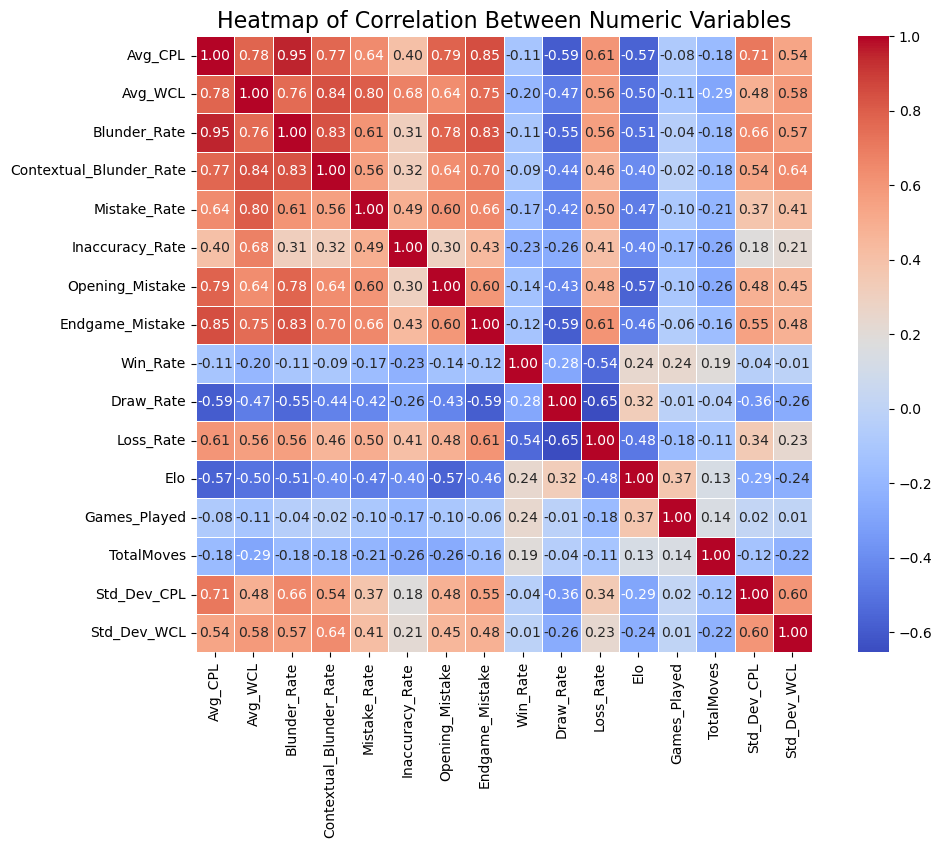

In [146]:
# Select only numeric columns, excluding PlayerID and Opening
numeric_columns = aggregated_stats.select_dtypes(include='number').drop(columns=['PlayerID'], errors='ignore')

# Compute the correlation matrix for numeric variables
correlation_matrix = numeric_columns.corr()

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(
    correlation_matrix,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    cbar=True,
    square=True,
    linewidths=0.5
)

plt.title("Heatmap of Correlation Between Numeric Variables", fontsize=16)
plt.show()

/var/folders/px/bhw6fd6j3kq_n8m44kf4rlbh0000gn/T/ipykernel_3284/2345157455.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


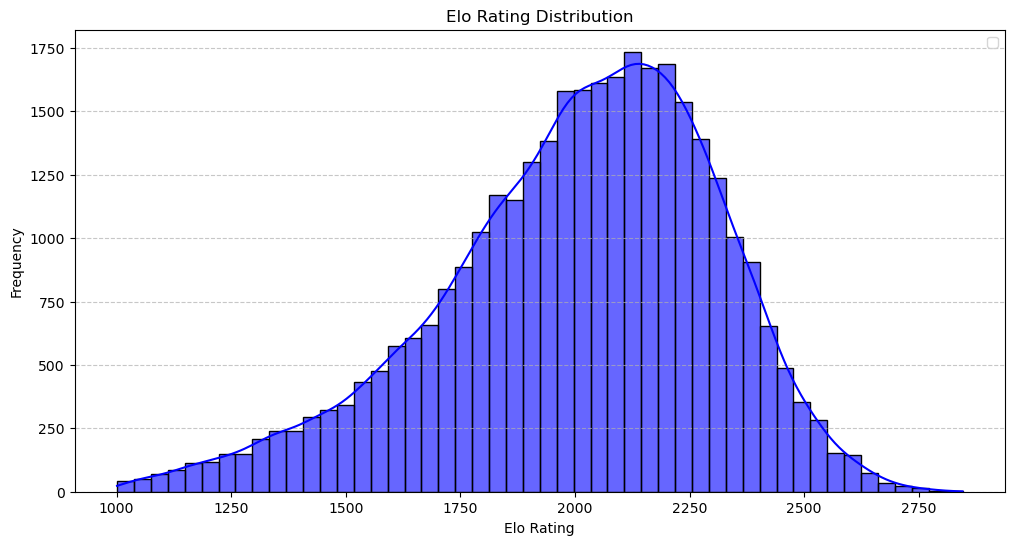

In [147]:
# Plot Elo distribution
plt.figure(figsize=(12, 6))

sns.histplot(aggregated_stats['Elo'], bins=50, kde=True, color='blue', alpha=0.6)

plt.title('Elo Rating Distribution')
plt.xlabel('Elo Rating')
plt.ylabel('Frequency')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

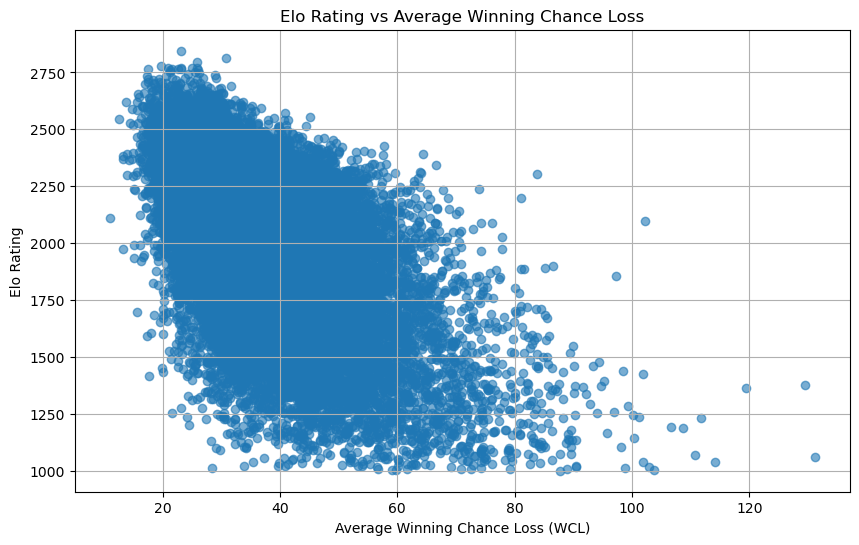

In [152]:
# Scatter plot of Avg_WCL vs Elo rating
plt.figure(figsize=(10, 6))
plt.scatter(aggregated_stats['Avg_CPL'], aggregated_stats['Elo'], alpha=0.6)
plt.title('Elo Rating vs Average Winning Chance Loss')
plt.xlabel('Average Winning Chance Loss (WCL)')
plt.ylabel('Elo Rating')
plt.grid(True)
plt.show()

### Linear Regression

In [213]:
df_aggregated = aggregated_stats.dropna()
df_aggregated_cleaned = df_aggregated[df_aggregated['Avg_CPL'] <= 100]
df_aggregated_cleaned.shape

(32667, 18)

In [239]:
from sklearn.model_selection import StratifiedShuffleSplit

df_aggregated_cleaned['Elo_bin'] = pd.cut(df_aggregated_cleaned['Elo'], bins=np.arange(1000, 3200, 200), labels=False, right = False)

X = df_aggregated_cleaned.drop(columns=['Elo', 'Elo_bin', 'Most_Common_Opening', 'PlayerID', 'Games_Played', 'TotalMoves', 'Std_Dev_CPL', 'Avg_WCL', 'Win_Rate', 'Draw_Rate', 'Contextual_Blunder_Rate', 'Endgame_Mistake', 'Std_Dev_WCL', 'Blunder_Rate'])
y = df_aggregated_cleaned['Elo']

stratify_bins = df_aggregated_cleaned['Elo_bin']

# Perform stratified split
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in splitter.split(X, stratify_bins):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

print("Train and test data prepared successfully.")

Train and test data prepared successfully.


/var/folders/px/bhw6fd6j3kq_n8m44kf4rlbh0000gn/T/ipykernel_3284/3328583528.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_aggregated_cleaned['Elo_bin'] = pd.cut(df_aggregated_cleaned['Elo'], bins=np.arange(1000, 3200, 200), labels=False, right = False)


In [240]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [241]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Initialize and train a linear regression model
model = LinearRegression()
model.fit(X_train_scaled, y_train)

# Predict and evaluate
y_pred = model.predict(X_test_scaled)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("MAE:", mae)
print("RMSE:", np.sqrt(mse))
print("R² Score:", r2)

MAE: 180.45016081880485
RMSE: 231.4403846583851
R² Score: 0.4112596394545672


In [242]:
# Print coefficients and intercept for linear regression
coefficients = pd.DataFrame(
    {"Feature": X_train.columns, "Coefficient": model.coef_}
).sort_values(by="Coefficient", ascending=False)
intercept = model.intercept_

print(f"Intercept: {intercept}")
print(coefficients)

Intercept: 2004.1065248556865
           Feature  Coefficient
1     Mistake_Rate    -6.289864
2  Inaccuracy_Rate   -42.079113
0          Avg_CPL   -51.386357
4        Loss_Rate   -52.455593
3  Opening_Mistake   -91.055293


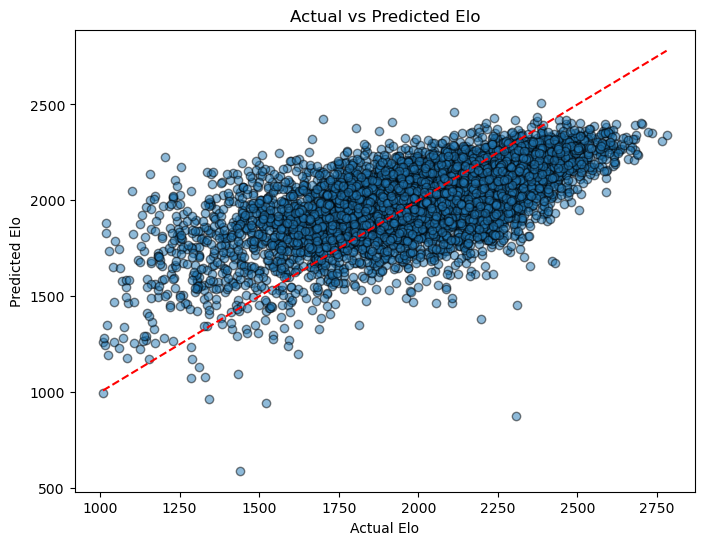

In [243]:
# Plot actual vs predicted values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5, edgecolors="k")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # 45-degree line
plt.xlabel("Actual Elo")
plt.ylabel("Predicted Elo")
plt.title("Actual vs Predicted Elo")
plt.show()

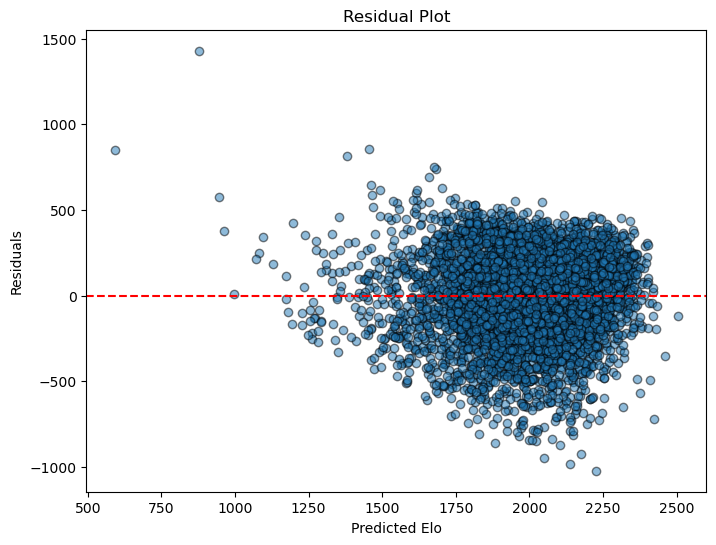

In [244]:
# Calculate residuals
residuals = y_test - y_pred

# Plot residuals
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuals, alpha=0.5, edgecolors="k")
plt.axhline(0, color='r', linestyle='--')  # Zero residual line
plt.xlabel("Predicted Elo")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()

### Other Regression Models

In [222]:
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Initialize and train Lasso regression
lasso_model = Lasso(alpha=0.1, random_state=42)
lasso_model.fit(X_train_scaled, y_train)

# Predict and evaluate
y_pred_lasso = lasso_model.predict(X_test_scaled)

print("Lasso Regression Results:")
print("MAE:", mean_absolute_error(y_test, y_pred_lasso))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_lasso)))
print("R² Score:", r2_score(y_test, y_pred_lasso))

Lasso Regression Results:
MAE: 180.44878991377664
RMSE: 231.12122772008775
R² Score: 0.4128822690876305


In [223]:
from sklearn.linear_model import Ridge

# Initialize and train Ridge regression
ridge_model = Ridge(alpha=1.0, random_state=42)
ridge_model.fit(X_train_scaled, y_train)

# Predict and evaluate
y_pred_ridge = ridge_model.predict(X_test_scaled)

print("Ridge Regression Results:")
print("MAE:", mean_absolute_error(y_test, y_pred_ridge))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_ridge)))
print("R² Score:", r2_score(y_test, y_pred_ridge))

Ridge Regression Results:
MAE: 180.46311896322044
RMSE: 231.14141210901013
R² Score: 0.4127797157201831


In [245]:
from sklearn.ensemble import RandomForestRegressor

# Initialize and train Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict and evaluate
y_pred_rf = rf_model.predict(X_test)

print("Random Forest Regression Results:")
print("MAE:", mean_absolute_error(y_test, y_pred_rf))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_rf)))
print("R² Score:", r2_score(y_test, y_pred_rf))

Random Forest Regression Results:
MAE: 167.1926391258534
RMSE: 216.36939080354492
R² Score: 0.4854386416365001


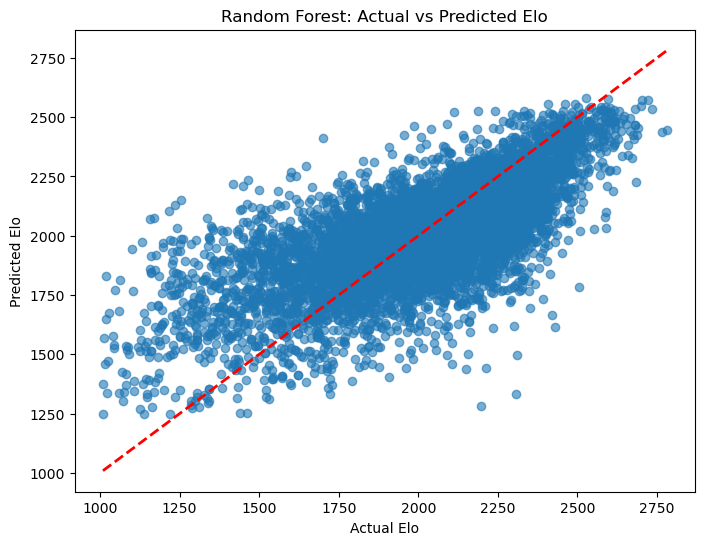

In [256]:
# Predict on the test set
y_pred_rf = rf_model.predict(X_test)

# Actual vs Predicted
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_rf, alpha=0.6)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', linewidth=2)
plt.xlabel("Actual Elo")
plt.ylabel("Predicted Elo")
plt.title("Random Forest: Actual vs Predicted Elo")
plt.show()

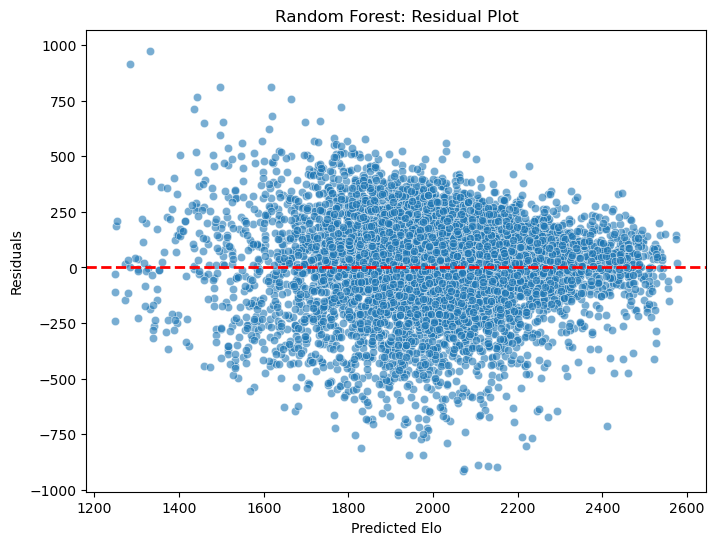

In [257]:
# Residuals
residuals = y_test - y_pred_rf

plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_pred_rf, y=residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--', linewidth=2)
plt.xlabel("Predicted Elo")
plt.ylabel("Residuals")
plt.title("Random Forest: Residual Plot")
plt.show()

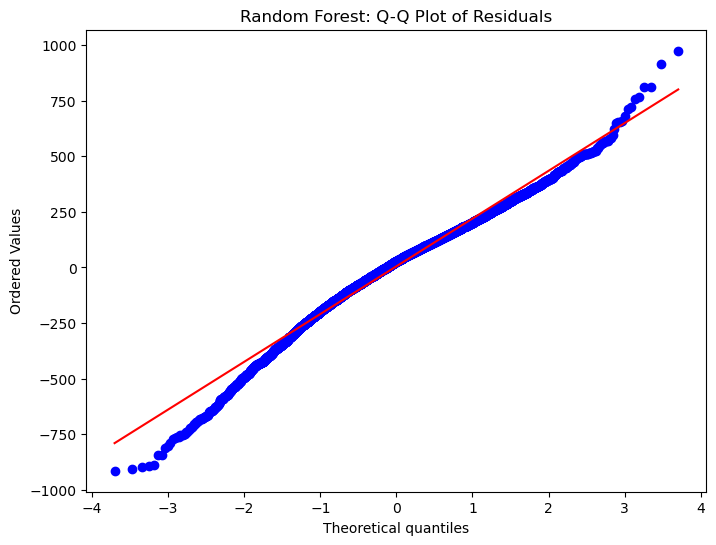

In [258]:
import scipy.stats as stats

# Q-Q Plot for residuals
plt.figure(figsize=(8, 6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("Random Forest: Q-Q Plot of Residuals")
plt.show()

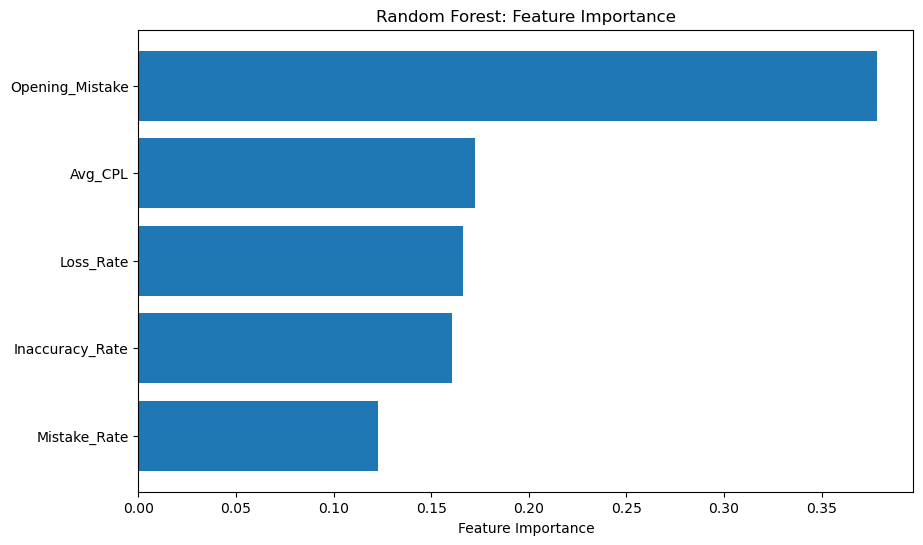

In [249]:
# Feature importance
importances = rf_model.feature_importances_
features = X_train.columns

# Sort features by importance
sorted_idx = np.argsort(importances)[::-1]
plt.figure(figsize=(10, 6))
plt.barh(range(len(features)), importances[sorted_idx], align='center')
plt.yticks(range(len(features)), [features[i] for i in sorted_idx])
plt.xlabel("Feature Importance")
plt.title("Random Forest: Feature Importance")
plt.gca().invert_yaxis()
plt.show()


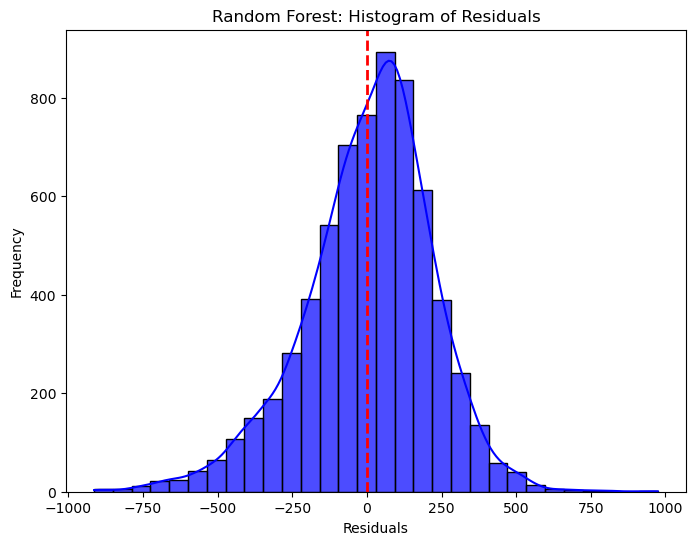

In [250]:
# Histogram of residuals
plt.figure(figsize=(8, 6))
sns.histplot(residuals, kde=True, bins=30, color='blue', alpha=0.7)
plt.axvline(0, color='red', linestyle='--', linewidth=2)
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Random Forest: Histogram of Residuals")
plt.show()

In [225]:
from sklearn.svm import SVR

# Initialize and train Support Vector Regressor
svr_model = SVR(kernel='rbf', C=1.0, epsilon=0.1)
svr_model.fit(X_train_scaled, y_train)

# Predict and evaluate
y_pred_svr = svr_model.predict(X_test_scaled)

print("Support Vector Regression Results:")
print("MAE:", mean_absolute_error(y_test, y_pred_svr))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_svr)))
print("R² Score:", r2_score(y_test, y_pred_svr))

Support Vector Regression Results:
MAE: 173.8457737736326
RMSE: 226.1678794229764
R² Score: 0.43777859425862187
